In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

import sys

from analysis import spikingResponse # custom object of trial-aligned spiking reponse
from analysis import pt, crosscorrel # plot_tools and CC-function

import matplotlib.pyplot as plt

# just to disable the HDMF cache namespace warnings, REMOVE to see them
import warnings
warnings.filterwarnings("ignore")

# 1) Loading the Optotagging results

In [2]:
Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 
                    'Optotagging-Results.npy'), allow_pickle=True).item()

# randomly subsample the negative units to 100 cells per session
np.random.seed(1)
for key in ['PV','SST']:
    for n, nUnits in enumerate(Optotagging[key+'_negative_units']):
        Optotagging[key+'_negative_units'][n] = np.random.choice(nUnits, 100, replace=False)

# 2) Preprocess the stimulus-evoked spikes

In [3]:
all = True

tstart, tstop, dt = -1, 301, 1e-3
t = tstart+dt*np.arange(int((tstop-tstart)/dt))

if False:
    # turn True to re-run the analysis
    
    # load data from API
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
    data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
    manifest_path = os.path.join(data_directory, "manifest.json")
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    sessions = cache.get_session_table()
    
    for key in ['PV', 'SST']:
        # loop over session

        for sessionID, positive_units, negative_units in zip(Optotagging[key+'_sessions'],
                                                             Optotagging[key+'_positive_units'],
                                                             Optotagging[key+'_negative_units']):
            if all:
                units  = np.concatenate([positive_units, negative_units])
            else:
                units = positive_units
            
            session = cache.get_session_data(sessionID)
            # stimulus infos for that session
            stim_table = session.get_stimulus_table()
            # fetch summary statistics 
            analysis_metrics = cache.get_unit_analysis_metrics_by_session_type(session.session_type)
            
            for protocol in [\
                             #'natural_movie_one_more_repeats',
                             'natural_movie_two',
                             #'natural_movie_one',
                             'natural_movie_three']:
                if protocol in np.unique(stim_table.stimulus_name):
                    cond = (stim_table.stimulus_name==protocol)
                    # get the number of repeats
                    blocks = np.unique(stim_table[cond].stimulus_block)
                    print(sessionID, protocol, 'n=%i blocks' % len(blocks))
                    for unit in units:
                        spike_matrix = np.zeros((len(blocks),len(t)), dtype=bool)
                        # get the spikes of that unit
                        spike_times = session.spike_times[unit]
                        # then just iterate over stimulus block:
                        for trial_idx, b in enumerate(blocks):
                            bCond = cond & (stim_table.stimulus_block==b)
                            trial_start = np.min(stim_table[bCond].start_time)
                            #tstop = np.max(stim_table[bCond].stop_time)
                            in_range = (spike_times > (trial_start + t[0])) * \
                                       (spike_times < (trial_start + t[-1]))
                            binned_times = ((spike_times[in_range] -\
                                             (trial_start + t[0])) / dt).astype('int')
                            spike_matrix[trial_idx, binned_times] = True      
                        Data = {'time_resolution':dt, 
                                'spike_matrix':spike_matrix,
                                't':t, 'keys':['t', 'spike_matrix']}
                        np.save(os.path.join('..', 'data', 'visual_coding', key,
                                             '%s_unit_%i.npy' % (protocol, unit)),
                                Data)

# 3) Showing an example session response

PV  -> sessionID:  721123822
[ok] PV positive natural_movie_one 950907398 found
[X]  PV positive natural_movie_one_more_repeats 950907398 missing
[ok] PV positive natural_movie_one 950908424 found
[X]  PV positive natural_movie_one_more_repeats 950908424 missing
[ok] PV positive natural_movie_one 950908547 found
[X]  PV positive natural_movie_one_more_repeats 950908547 missing
[ok] PV positive natural_movie_one 950909518 found
[X]  PV positive natural_movie_one_more_repeats 950909518 missing
[ok] PV positive natural_movie_one 950910660 found
[X]  PV positive natural_movie_one_more_repeats 950910660 missing
[ok] PV positive natural_movie_one 950910784 found
[X]  PV positive natural_movie_one_more_repeats 950910784 missing
[ok] PV positive natural_movie_one 950913049 found
[X]  PV positive natural_movie_one_more_repeats 950913049 missing
[ok] PV positive natural_movie_one 950913115 found
[X]  PV positive natural_movie_one_more_repeats 950913115 missing
[ok] PV positive natural_movie_one 

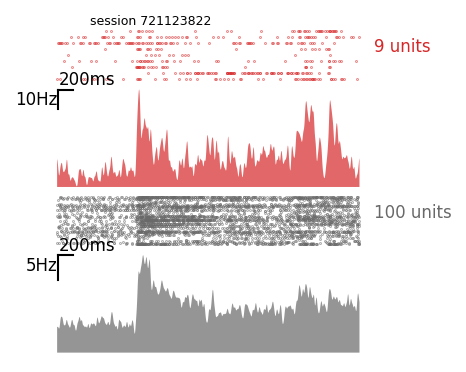

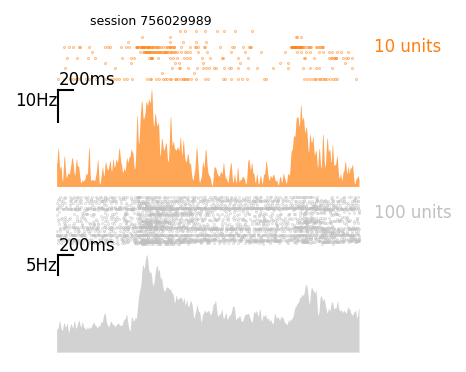

In [4]:
examples = {'PV':{'sessionID':0, 
                  'positive_color':'tab:red', 
                  'negative_color':'dimgrey'},
            'SST':{'sessionID':2, 
                   'positive_color':'tab:orange', 
                   'negative_color':'silver'}}

rate_smoothing = 10e-3
tmax = 3


for c, cellType in enumerate(examples.keys()):

    fig, AX = pt.figure(axes_extents=[[[1,1]],[[1,2]],[[1,1]],[[1,2]]], 
                        hspace=0.1, figsize=(1.6,.55))
    sessionID = examples[cellType]['sessionID']
    fig.suptitle(\
            'session %i\n' % Optotagging['%s_sessions' % cellType][sessionID], 
                 fontsize=6)
    print(cellType, ' -> sessionID: ', 
          Optotagging['%s_sessions' % cellType][sessionID])

    for k, key in enumerate(['positive', 'negative']):
        rates = []
        for u, unit in enumerate(Optotagging['%s_%s_units' % (cellType, key)][sessionID]):
            for protocol in ['natural_movie_one', 'natural_movie_one_more_repeats']:
                filename = os.path.join('..', 'data', 'visual_coding', cellType, 
                                        '%s_unit_%i.npy' % (protocol, unit))
                if os.path.isfile(filename):
                    print('[ok]', cellType, key, protocol, unit, 'found')
                    spikeResp = spikingResponse(None, None, None, filename=filename)
                    cond = spikeResp.t<tmax
                    rates.append(spikeResp.get_rate(smoothing=rate_smoothing)[cond])

                    # showing spikes on the first repeat only
                    sCond = spikeResp.spike_matrix[0,:] & cond
                    AX[2*k].scatter(spikeResp.t[sCond], u+0*spikeResp.t[sCond], 
                                    s=0.05,
                                    color=examples[cellType]['%s_color'%key])
                else:
                    print('[X] ', cellType, key, protocol, unit, 'missing')
        print('number of repeats:', spikeResp.spike_matrix.shape[0], '  ', key, cellType)

        AX[2*k+1].fill_between(spikeResp.t[cond], 
                               0*spikeResp.t[cond], np.mean(rates, axis=0),
                               alpha=.7, lw=0,
                               color=examples[cellType]['%s_color'%key])
        pt.annotate(AX[2*k], '%i units' % len(rates), (1,0.5),
                               color=examples[cellType]['%s_color'%key])
    for ax in AX:
        ax.axis('off')
    pt.draw_bar_scales(AX[1], Xbar=0.2, Xbar_label='200ms', Ybar=10, Ybar_label='10Hz')
    pt.draw_bar_scales(AX[3], Xbar=0.2, Xbar_label='200ms', Ybar=5, Ybar_label='5Hz')
    pt.set_common_xlims(AX)
    fig.savefig('../figures/visual_coding/%s-session-natural-movie.svg' % cellType)

# 4) Compute the time-varying rate of the "+" and "-" units 

In [5]:
# loop over frames to build the time course

rate_smoothing = 10e-3

PROTOCOLS = {'natural_movie_three':['natural_movie_three',
                                    ''],
             'natural_movie_one':['natural_movie_one_more_repeats',
                                  'natural_movie_one']}

for p in PROTOCOLS:
    
    protocols = PROTOCOLS[p]

    RATES = {}
    for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
        RATES[key+'_posUnits'] = []
        RATES[key+'_negUnits'] = []
        for sessionID in range(len(Optotagging[key+'_sessions'])):
            
            if len(Optotagging[key+'_positive_units'][sessionID])>1:
                # only sessions with phototagged units
                
                for u, rates, units, c in zip(range(2), [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                                       [Optotagging[key+'_positive_units'][sessionID], Optotagging[key+'_negative_units'][sessionID]],
                                       [color, 'tab:grey']):
                    
                    for unit in units:
                        filename0 = os.path.join('..', 'data', 'visual_coding', key, 
                                                '%s_unit_%i.npy' % (protocols[0], unit))
                        filename1 = os.path.join('..', 'data', 'visual_coding', key, 
                                                '%s_unit_%i.npy' % (protocols[1], unit))
                        if os.path.isfile(filename0):
                            spikeResp = spikingResponse(None, None, None, filename=filename0)
                            rates.append(spikeResp.get_rate(smoothing=rate_smoothing))
                        elif os.path.isfile(filename1):
                            spikeResp = spikingResponse(None, None, None, filename=filename1)
                            rates.append(spikeResp.get_rate(smoothing=rate_smoothing))
                            
    RATES['time'] = spikeResp.t
    np.save(os.path.join('..', 'data', 'visual_coding', 'RATES_%s.npy' % p), RATES)

[247  39 473 487 212 320 201   5 541 367 429  37  96 563 465 177 162 223
 237 229  26 295 192  63 111 131  82 173 363 110   7 381 315 166  31 534
  76 271 482 269 478 167  12 391 495 398 128 434 159  52 275 150 470 264
 163  80 404 157 552  77 497 250 198 134 448 479 268 336 142 299 147 307
 283 244 277 335  41  66 340  47 168  97  59 512 352  92 158 360  55 107
 419 528 539  87 510 330  93 149 504 339 242 573 263 348 344 410   9 331
 207 171  98 152 280 146 433 454 143 455 185 206 462 519 437 216 585  23
 323 431 591   8 261 475 252 498 349 375  75  67 524 439  15 492 317 304
 178 441]
[ 787  667 1143 1154  131   73  946  179  406  442  598 1134  861  637
  587  806  132  688 1046  205  535  989  121   21  918 1123  533  539
 1009  833  822  435  501  426  508  802  166  215 1091 1059  448  983
 1156   84  578 1061  752 1094  231 1052  119  451  687 1144  365  307
  424  459  776  915 1085  792  937 1151 1124  398  942  870  540 1089
   63  429  497  351  831  116  537  495 1034  466 

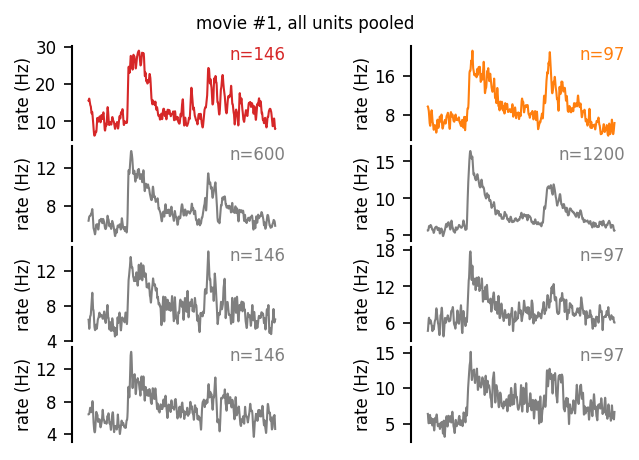

In [32]:
RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,4), hspace=0.1, figsize=(1.3,1))
fig.suptitle('movie #1, all units pooled')

tCond = RATES['time']<4

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    for u, rates, c in zip(range(4), 
                           [RATES[key+'_posUnits'], RATES[key+'_negUnits'],
                           [RATES[key+'_negUnits'][i] for i in np.random.choice(np.arange(len(RATES[key+'_negUnits'])), len(RATES[key+'_posUnits']), replace=False)],
                           [RATES[key+'_negUnits'][i] for i in np.random.choice(np.arange(len(RATES[key+'_negUnits'])), len(RATES[key+'_posUnits']), replace=False)]],
                           [color, 'tab:grey', 'tab:grey', 'tab:grey']):  
        if len(rates)>0:
            pt.plot(RATES['time'][tCond], np.mean(rates, axis=0)[tCond],
                    #sy=0.*np.std(rates, axis=0)[tCond],
                    ax=AX[u][k], color=c)
            pt.annotate(AX[u][k], 'n=%i' % len(rates), (1,1), va='top', ha='right', color=c)
            pt.set_plot(AX[u][k], ['left','bottom'] if u==4 else ['left'], 
                        ylabel='rate (Hz)', xlabel='time (s)' if u==4 else '')

# 5) Compute the Cross.-Correlation and its decay

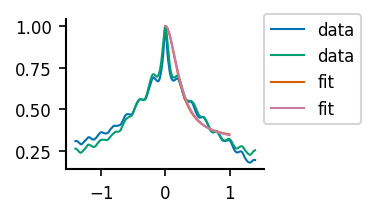

In [74]:
# Exponential fit to quantify the decay

from scipy.optimize import minimize

def gaussian(t, X):
    return (1-X[2])*np.exp(-(t-X[1])**2/2/X[0]**2)+X[2]

def lorentzian(t, X):
    return (1-X[2])*(1./(1+(t)**2/2/X[0]**2))+X[2]
    
def fit_half_width(shift, array,
                   min_time=50e-3,
                   max_time=1000e-3):
    def func(X):
        #return np.sum(np.abs(gaussian(shift, X)-array))
        return np.sum(np.abs(lorentzian(shift, X)-array))
    res = minimize(func, [3*min_time,0,1],
                   bounds=[[min_time, max_time],
                           [-max_time, max_time],
                           [0,1]], method='L-BFGS-B')
    return res.x

if True:
    plt.plot(time_shift, CCF1/np.max(CCF1), label='data')
    plt.plot(time_shift, CCF2/np.max(CCF2), label='data')
    #plt.plot(time_shift, gaussian(time_shift, fit_half_width(time_shift, CCF/np.max(CCF))), label='fit')
    fit_cond = (time_shift>0) & (time_shift<1)
    plt.plot(time_shift[fit_cond], lorentzian(time_shift[fit_cond], fit_half_width(time_shift[fit_cond], CCF1[fit_cond]/np.max(CCF1))), label='fit')
    plt.plot(time_shift[fit_cond], lorentzian(time_shift[fit_cond], fit_half_width(time_shift[fit_cond], CCF2[fit_cond]/np.max(CCF2))), label='fit')
    #plt.plot(ts, (1-C)*np.exp(-ts/tau)+C, '--', label='exp. fit')
    plt.legend(loc=(1,0.3))

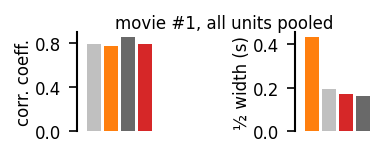

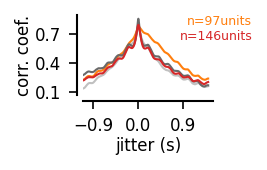

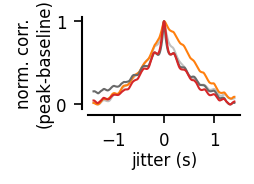

In [75]:

RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig1, [ax11, ax12] = plt.subplots(1, 2, figsize=(2.5,0.9))
fig1.subplots_adjust(wspace=2, top=0.85)
fig1.suptitle('movie #1, all units pooled\n')
fig2, ax2 = pt.figure(figsize=(1.,0.85))
fig3, ax3 = plt.subplots(1, figsize=(1.3, 0.8))

np.random.seed(5)

for k, key, pos_color, neg_color in zip(range(2),
                                        ['SST', 'PV'], 
                                        ['tab:orange', 'tab:red'],
                                        ['silver', 'dimgrey']):

    neg_rates_All = np.mean(RATES['%s_negUnits' % key], axis=0)

    # rates of positive units
    pos_rates = np.mean(RATES['%s_posUnits' % key], axis=0)
    # rates of negative units subsampled to the number of positive units (to have a fair comp)
    neg_rates = np.mean([RATES[key+'_negUnits'][i] for i in np.random.choice(np.arange(len(RATES[key+'_negUnits'])), len(RATES[key+'_posUnits']), replace=False)], axis=0)

    pt.annotate(ax2, k*'\n'+'n=%iunits' % len(RATES['%s_posUnits' % key]), (1.3,1),
                va='top', ha='right', color=pos_color, fontsize=6)
    #pt.annotate(ax3, k*'\n'+'n=%iunits' % len(RATES['%s_negUnits' % key]), (1.3,1),
    #            va='top', ha='right', color=neg_color, fontsize=6)
    
    CCF1, time_shift = crosscorrel(neg_rates_All-np.mean(neg_rates_All), neg_rates-np.mean(neg_rates),
                                  1.4, RATES['time'][1]-RATES['time'][0])
    ax2.plot(time_shift, CCF1, color=neg_color)
    # ax3.plot(time_shift, CCF/np.max(CCF), color=neg_color)
    ax3.plot(time_shift, (CCF1-np.min(CCF1))/(np.max(CCF1)-np.min(CCF1)), 
             color=neg_color)
    ax11.bar([2*k], [CCF1[int(len(time_shift)/2)]], color=neg_color)
    
    # fit for half width
    fit_cond = (time_shift>0) & (time_shift<1)
    tau0 = fit_half_width(time_shift[fit_cond], CCF1[fit_cond]/np.max(CCF1))[0]
    ax12.bar([2*k+1], [tau0], color=neg_color)


    CCF2, time_shift = crosscorrel(neg_rates_All-np.mean(neg_rates_All), pos_rates-np.mean(pos_rates),
                                  1.4, RATES['time'][1]-RATES['time'][0])
    ax2.plot(time_shift, CCF2, color=pos_color)
    # ax3.plot(time_shift, CCF/np.max(CCF), color=pos_color)
    ax3.plot(time_shift, (CCF2-np.min(CCF2))/(np.max(CCF2)-np.min(CCF2)), 
             color=pos_color)

    ax11.bar([2*k+1], [CCF2[int(len(time_shift)/2)]], color=pos_color)
    
    # gaussian fit for width
    fit_cond = (time_shift>0) & (time_shift<1)
    tau = fit_half_width(time_shift[fit_cond], CCF2[fit_cond]/np.max(CCF2))[0]
    ax12.bar([2*k], [tau], color=pos_color)
    #ax13.bar([k], [1e3*(tau-tau0)], color=pos_color)
    
pt.set_plot(ax11, ['left'], #yticks=[0,0.2,0.4],
            ylabel='corr. coeff.')
pt.set_plot(ax12, ['left'], yticks=[0,0.2,0.4],
            ylabel=u'\u00bd' + ' width (s)')
pt.set_plot(ax2, xlabel='jitter (s)', 
            #title='"-" vs "+" units', 
            ylabel='corr. coef.',
            yticks=[0.1,0.4,0.7],
            xlim=[-1.1,1.5], 
            xticks=[-0.9,0,0.9])
pt.set_plot(ax3, xlabel='jitter (s)', 
            ylabel='norm. corr.\n(peak-baseline)',
            xlim=[-1.5,1.5], yticks=[0,1])

fig2.savefig('../figures/visual_coding/CC_movie1_units_pooled.svg')
fig3.savefig('../figures/visual_coding/normCC_movie1_units_pooled.svg')
fig2.savefig('../figures/Figure5/CC_movie1_units_pooled.pdf')

# 6) Same but analyzing per session

## 6.1) compute the time-varying rate

In [84]:
# loop over frames to build the time course
PROTOCOLS = {'natural_movie_three':['natural_movie_three'],
             'natural_movie_one':['natural_movie_one', 'natural_movie_one_more_repeats']}

np.random.seed(0)

for p in PROTOCOLS:
    
    protocols = PROTOCOLS[p]
    
    RATES = {}
    for k, cellType, color in zip(range(2),
                             ['PV', 'SST'],
                             ['tab:red','tab:orange']):

        RATES['%s_posUnits' % cellType] = []
        for ii in range(10):
            RATES['%s_negUnits_subsampled%i' % (cellType,ii)] = []
        RATES['%s_negUnits' % cellType] = []
        RATES['%s_n_per_session' % cellType] = []

        for sessionID in range(len(Optotagging[cellType+'_sessions'])):

            posUnits = Optotagging[cellType+'_positive_units'][sessionID]
            negUnits = Optotagging[cellType+'_negative_units'][sessionID]
            posRates, negRates = [], []

            for protocol in protocols:

                for units, rates in zip([negUnits, posUnits], [negRates, posRates]):
                    for unit in units:
                        filename = os.path.join('..', 'data', 'visual_coding', cellType, 
                                                '%s_unit_%i.npy' % (protocol, unit))
                        if os.path.isfile(filename):
                            spikeResp = spikingResponse(None, None, None, filename=filename)
                            rates.append(spikeResp.get_rate(smoothing=5e-3))

            if (len(posRates)>1):
                # only if more than one positive units
                RATES['%s_posUnits' % cellType].append(np.mean(posRates, axis=0))
                RATES['%s_negUnits' % cellType].append(np.mean(negRates, axis=0))
                for ii in range(10):
                    RATES['%s_negUnits_subsampled%i' % (cellType,ii)].append(\
                        np.mean([negRates[nn] for nn in np.random.choice(np.arange(len(negRates)), len(posRates), replace=False)], axis=0))
                RATES['%s_n_per_session' % cellType].append(len(posRates))
            else:
                print('session %i no ' % sessionID, cellType, p)
                
    RATES['time'] = spikeResp.t
    np.save(os.path.join('..', 'data', 'visual_coding',
                         'RATES_per_session_%s.npy' % p), RATES)

session 3 no  PV natural_movie_three
session 4 no  PV natural_movie_three
session 5 no  PV natural_movie_three
session 6 no  SST natural_movie_three
session 7 no  SST natural_movie_three
session 8 no  SST natural_movie_three
session 9 no  SST natural_movie_three
session 10 no  SST natural_movie_three
session 11 no  SST natural_movie_three


In [83]:
len(RATES['%s_negUnits_subsampled%i' % (cellType,ii)]), len(RATES['%s_negUnits' % cellType])
RATES['%s_n_per_session' % cellType]

[9, 2, 27]

## 6.2) Compute the cross-correlation

In [ ]:
CCs = {'dt':RATES['time'][1]-RATES['time'][0],
       'extent':1.5}

for cellType in ['PV', 'SST']:
    for u in ['pos', 'neg']:
        CCs[cellType+'_%sUnits' % u] = []
    CCs['%s_n_per_session' % cellType] = []
    for ii in range(10):
        CCs['%s_negUnits_subsampled%i' % (cellType,ii)] = []
    
for p in PROTOCOLS:
    
    RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_per_session_%s.npy' % p),
                    allow_pickle=True).item()

    for k, cellType, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):

        for u in ['pos', 'neg']:
            
            # loop over session:
            for session in range(len(RATES['%s_n_per_session' % cellType])):
                CCs[cellType+'_%sUnits' % u].append(\
                            crosscorrel(RATES['%s_negUnits' % cellType][session],
                                        RATES['%s_%sUnits' % (cellType,u)][session],
                                        CCs['extent'], CCs['dt'])[0])
                CCs['%s_n_per_session' % cellType].append(RATES['%s_n_per_session' % cellType][session])
                for ii in range(10):
                    CCs['%s_negUnits_subsampled%i' % (cellType,ii)].append(\
                                                crosscorrel(RATES['%s_negUnits' % cellType][session],
                                                            RATES['%s_negUnits_subsampled%i' % (cellType,ii)][session],
                                                            CCs['extent'], CCs['dt'])[0])
                
# just to get the time shift
_, CCs['time_shift'] = crosscorrel(0*RATES['time'], 0*RATES['time'], CCs['extent'], CCs['dt'])

np.save(os.path.join('..', 'data', 'visual_coding', 'CC_per_session_natural_movies.npy'), CCs)

302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3
302000
3


## 6.3) Analyze and plot

PV pos 75 +/- 14
PV neg 50 +/- 0
SST pos 240 +/- 63
SST neg 58 +/- 6


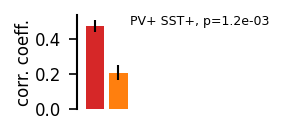

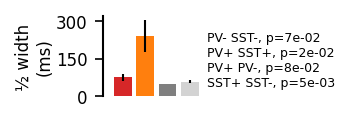

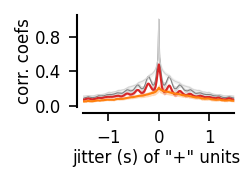

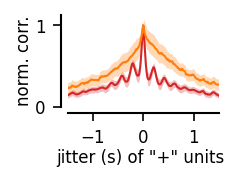

In [73]:
from scipy import stats
import itertools

CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_per_session_natural_movies.npy'),
              allow_pickle=True).item()


fig11, ax11 = pt.figure(figsize=(.6,1.))
fig12, ax12 = pt.figure(figsize=(0.85,0.85))
fig2, ax2 = plt.subplots(1, figsize=(1.3, 0.8))
fig3, ax3 = plt.subplots(1, figsize=(1.3, 0.8))

i0 = int(len(CCs['time_shift'])/2) # index of 0-lag correl

for k, cellType, color1, color2 in zip(range(2),
                                  ['PV', 'SST'],
                                  ['tab:red','tab:orange'],
                                  ['tab:grey', 'lightgray']):
    
    for i, pn, color in zip(range(2), ['pos', 'neg'], [color1, color2]):

        # 0-lag correl
        CCs['%s_%s0CC' % (cellType,pn)] = np.array([cc[i0] for cc in CCs['%s_%sUnits' % (cellType, pn)]])
        if not i:
            ax11.bar([k], [np.mean(CCs['%s_%s0CC' % (cellType,pn)])], 
                      yerr=[stats.sem(CCs['%s_%s0CC' % (cellType,pn)])],
                      color=color)

        # gaussian fit for width
        fit_cond = (CCs['time_shift']>0) & (CCs['time_shift']<1)
        CCs['%s_%sWidths' % (cellType,pn)] = np.array([fit_half_width(CCs['time_shift'][fit_cond], CCF[fit_cond]/np.max(CCF))[0]\
                                                        for CCF in CCs['%s_%sUnits' % (cellType, pn)]])
        ax12.bar([k+2*i], [1e3*np.mean(CCs['%s_%sWidths' % (cellType,pn)])], 
                  yerr=[1e3*stats.sem(CCs['%s_%sWidths' % (cellType,pn)])],
                  color=color)
            
    mean = np.mean(CCs[cellType+'_posUnits'], axis=0)
    pt.plot(CCs['time_shift'], mean/np.max(mean),
            sy=stats.sem(CCs[cellType+'_negUnits'], axis=0)/np.max(mean),
            color=color1, ax=ax3)
    
    mean = np.mean(CCs[cellType+'_negUnits'], axis=0)
    pt.plot(CCs['time_shift'], mean/np.max(mean), 
            sy=stats.sem(CCs[cellType+'_negUnits'], axis=0)/np.max(mean),
            color=color2, lw=0.5, ax=ax2)
    pt.plot(CCs['time_shift'], np.mean(CCs[cellType+'_posUnits'], axis=0), 
            sy=stats.sem(CCs[cellType+'_posUnits'], axis=0)/np.max(mean),
            color=color1, ax=ax2)

# statistic
pt.annotate(ax11, 'PV+ SST+, p=%.1e' % stats.mannwhitneyu(CCs['PV_pos0CC'], CCs['SST_pos0CC']).pvalue,
            (1., 1.), va='top', fontsize=6)

for gt, cell in itertools.product(['PV', 'SST'], ['pos', 'neg']):
    print(gt, cell, '%.0f +/- %.0f' % (1e3*np.mean(CCs['%s_%sWidths' % (gt,cell)]),
                                       1e3*stats.sem(CCs['%s_%sWidths' % (gt,cell)])) )
    
pt.annotate(ax12, '\n PV- SST-, p=%.0e' % stats.mannwhitneyu(CCs['PV_negWidths'], CCs['SST_negWidths']).pvalue,
            (1., 1.), va='top', fontsize=6)
pt.annotate(ax12, '\n\n PV+ SST+, p=%.0e' % stats.mannwhitneyu(CCs['PV_posWidths'], CCs['SST_posWidths']).pvalue,
            (1., 1.), va='top', fontsize=6)
pt.annotate(ax12, '\n\n\n PV+ PV-, p=%.0e\n' % stats.mannwhitneyu(CCs['PV_posWidths'], CCs['PV_negWidths']).pvalue,
            (1., 1.), va='top', fontsize=6)
pt.annotate(ax12, '\n\n\n\n SST+ SST-, p=%.0e\n' % stats.mannwhitneyu(CCs['SST_posWidths'], CCs['SST_negWidths']).pvalue,
            (1., 1.), va='top', fontsize=6)

pt.set_plot(ax11, ['left'], #yticks=[0,0.2,0.4],
            ylabel='corr. coeff.')
pt.set_plot(ax12, ['left'], #yticks=[0,200,400],
            ylabel=u'\u00bd' + ' width\n(ms)')
pt.set_plot(ax2, xlabel='jitter (s) of "+" units ', 
            ylabel='corr. coefs',
            xlim=[-1.5,1.5])
pt.set_plot(ax3, xlabel='jitter (s) of "+" units ', 
            ylabel='norm. corr.',
            xlim=[-1.5,1.5], yticks=[0,1])

fig12.savefig('../figures/visual_coding/decays_per_session.svg')
fig12.savefig('../figures/Figure5/decays_per_session.svg')

## Cross-correlation per cell 
### (unusable --> rate waveforms are way too noisy at the required temporal sampling)

In [40]:
from scipy import signal

window = [-1.5, 1.5]

CCs = {'dt':RATES['time'][1]-RATES['time'][0],
       'extent':1.5}

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    
    popRate = np.mean(RATES['%s_negUnits' % key], axis=0)

    # positive units
    CCs[key+'_posUnits'], CCs['time_shift'] = crosscorrel(popRate, popRate, CCs['extent'], CCs['dt'])
    
    # loop over negative units
    CCs[key+'_negUnits'] = []
    for rate in RATES['%s_negUnits' % key]:
        CCs[key+'_negUnits'].append(\
                        crosscorrel(popRate, rate, CCs['extent'], CCs['dt'])[0])
        
np.save(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'), CCs)

Text(0.5, 0.98, 'cross-correl. "-" vs "+" units')

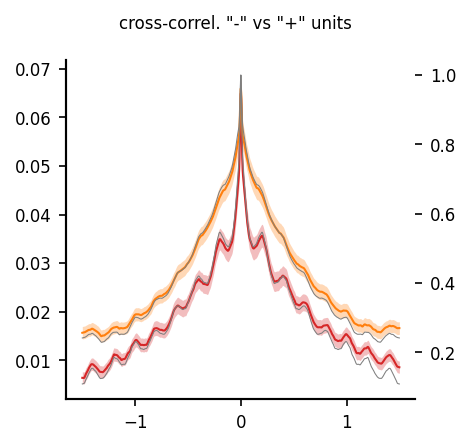

In [45]:
CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'),
              allow_pickle=True).item()

fig, ax = plt.subplots(1, figsize=(3,3))
ax2 = ax.twinx()

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    pt.plot(CCs['time_shift'], np.mean(CCs[key+'_negUnits'], axis=0), 
            sy=stats.sem(CCs[key+'_negUnits'], axis=0), color=color, ax=ax)
    pt.plot(CCs['time_shift'], CCs[key+'_posUnits'], 
            color='tab:grey', lw=0.5, ax=ax2)
    
#pt.set_plot(ax, xlabel='$\delta$ time (s)', xlim=[-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')

# Exporting Negative-Units Rates as Inputs to Stimulation

In [ ]:
RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig1, ax = pt.figure(figsize=(2,1), left=0.2)

tlim = [-1.1, 20]
cond = (RATES['time']>tlim[0]) & (RATES['time']<tlim[1])

for k, key, pos_color, neg_color in zip(range(2),
                                        ['SST', 'PV'], 
                                        ['tab:orange', 'tab:red'],
                                        ['silver', 'dimgrey']):

    neg_rates = np.mean(RATES['%s_negUnits' % key], axis=0)
    pt.annotate(ax, 2*k*'\n'+'%.1fHz' % np.std(4.*neg_rates), (0,1),
                ha='right', va='top', color=neg_color)
    ax.plot(RATES['time'][cond], (neg_rates[cond]-np.mean(neg_rates))/np.std(neg_rates), 
            color=neg_color)
    pos_rates = np.mean(RATES['%s_posUnits' % key], axis=0)
    pt.annotate(ax, (2*k+1)*'\n'+'%.1fHz' % np.std(4.*pos_rates), (0,1),
                ha='right', va='top', color=pos_color)
    ax.plot(RATES['time'][cond], (pos_rates[cond]-np.mean(pos_rates))/np.std(pos_rates), 
            color=pos_color)

ax.plot([tlim[1],tlim[1]-1], [8, 8], 'k-')
ax.annotate('1s',(tlim[1]-.5,8.5), ha='center') 
ax.plot(-1*np.ones(2), [4, 8], 'k-')
pt.set_plot(ax, [], xlim=tlim)

In [ ]:
RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig1, ax = pt.figure(figsize=(2,1), left=0.2)

tlim = [-1.1, 10]
cond = (RATES['time']>tlim[0]) & (RATES['time']<tlim[1])

neg_rates = 0.5*(\
        np.mean(RATES['PV_negUnits'], axis=0)+\
        np.mean(RATES['SST_negUnits'], axis=0))
scaled_neg_rates = (neg_rates-np.mean(neg_rates))/np.std(neg_rates)


pt.annotate(ax, '%.1fHz' % np.std(4.*neg_rates), (0,1),
            ha='right', va='top', color=neg_color)

ax.fill_between(RATES['time'][cond], 
                np.min(scaled_neg_rates),
                scaled_neg_rates[cond],
                color=neg_color, lw=0, alpha=.5)

for k, key, pos_color in zip(range(2),
                            ['SST', 'PV'], 
                            ['tab:orange', 'tab:red']):

    pos_rates = np.mean(RATES['%s_posUnits' % key], axis=0)
    pt.annotate(ax, (k+1)*'\n'+'%.1fHz' % np.std(4.*pos_rates), (0,1),
                ha='right', va='top', color=pos_color)
    ax.plot(RATES['time'][cond], (pos_rates[cond]-np.mean(pos_rates))/np.std(pos_rates), 
            color=pos_color)

ax.plot([tlim[1],tlim[1]-1], [8, 8], 'k-')
ax.annotate('1s',(tlim[1]-.5,8.5), ha='center') 
ax.plot(-1*np.ones(2), [4, 8], 'k-')
pt.set_plot(ax, [], xlim=tlim)